In [12]:
import os, time
from tqdm import tnrange, tqdm_notebook, tqdm
import itertools
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
from torch.autograd import Variable
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

In [13]:
now = int(time.time())

In [14]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [15]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 8)

%matplotlib inline

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
torch.cuda.is_available()

True

In [18]:
device_ids = [0]

In [19]:
batch_size = 128
num_epochs = 100

z_dimension = 100

In [20]:
img_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
#     transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    transforms.Normalize((.5, ), (.5, ))
])

dataset = datasets.MNIST('~/data/mnist', transform=img_transform) #, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [21]:
def to_categorical(y, num_columns):
    y_cat = np.zeros((y.shape[0], num_columns))
    y_cat[range(y.shape[0]), y] = 1.

#     return Variable(FloatTensor(y_cat))
    return torch.from_numpy(y_cat).float().cuda()

In [29]:
def gen_noise(batch_size, label, code):
    prefix = np.zeros((batch_size, z_dimension))
    prefix[np.arange(batch_size), label] = 1
    z = np.random.normal(0, .3, (batch_size, z_dimension))
#     prefix = prefix / np.linalg.norm(prefix)
#     z = z + prefix
    z[:, :10] = 0
    z[np.where(prefix.astype(int))] = 1
    z[:, 10:12] = code
    return torch.from_numpy(z).float().view(-1, z_dimension, 1, 1).to(device)

In [30]:
# b = 10
# label = np.random.randint(0, 10, 10)
# a = np.random.uniform(-1, 1, (10, 2))
# print(a)
# gen_noise(10, label, a)

[[ 0.43370307 -0.26283894]
 [ 0.43087245 -0.02116618]
 [-0.62022598 -0.05301836]
 [ 0.63224385 -0.72483486]
 [ 0.82711163 -0.66959952]
 [ 0.60586664  0.24075513]
 [ 0.36296638  0.51802136]
 [ 0.43727275 -0.82088488]
 [ 0.34464176 -0.71873373]
 [ 0.17289824 -0.800973  ]]
[ 0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.20817257  0.19763994
  0.1211483  -0.19524738 -0.10245985 -0.04810968  0.2996502   0.40608202
  0.01376217 -0.08962169  0.35203703 -0.61328976 -0.23165423  0.24080949
  0.24284343 -0.30987136  0.19635726  0.13418287 -0.09367486  0.13251686
 -0.30217805 -0.29125405 -0.18459838  0.43572835  0.09029389 -0.20650372
  0.50198278 -0.39840687 -0.41944106 -0.13938068 -0.22334114 -0.33693656
 -0.25466332 -0.34374525 -0.15245569  0.49987578  0.15419103 -0.01998169
  0.04458551  0.01579128 -0.66606251  0.28614335  0.35485536  0.07035591
 -0.04261738 -0.3282397  -0.12557447  0.06746556 -0.03527875  0.27886899
  0.312

RuntimeError: CUDA error: out of memory

In [10]:
# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()

#         def discriminator_block(in_filters, out_filters, bn=True):
#             """Returns layers of each discriminator block"""
#             block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1),
#                      nn.LeakyReLU(0.2, inplace=True),
#                      nn.Dropout2d(0.25)]
#             if bn:
#                 block.append(nn.BatchNorm2d(out_filters, 0.8))
#             return block

#         self.conv_blocks = nn.Sequential(
#             *discriminator_block(1, 16, bn=False),
#             *discriminator_block(16, 32),
#             *discriminator_block(32, 64),
#             *discriminator_block(64, 128),
#         )

#         # The height and width of downsampled image
#         ds_size = 32 // 2**4

#         # Output layers
#         self.adv_layer = nn.Sequential(nn.Linear(128*ds_size**2, 1))
#         self.aux_layer = nn.Sequential(
#             nn.Linear(128*ds_size**2, 10),
#             nn.Softmax()
#         )
#         self.latent_layer = nn.Sequential(nn.Linear(128*ds_size**2, 2))

#     def forward(self, img):
#         out = self.conv_blocks(img)
#         out = out.view(out.shape[0], -1)
#         validity = self.adv_layer(out)
#         label = self.aux_layer(out)
#         latent_code = self.latent_layer(out)

#         return validity, label, latent_code

class Discriminator(nn.Module):
    def __init__(self, d=64):
        super(Discriminator, self).__init__() # b 1 32 32
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, d, 4, 2, 1),
            nn.LeakyReLU(.2, True),
            nn.BatchNorm2d(d),
        ) # b d 16 16
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(d, d*2, 4, 2, 1),
            nn.LeakyReLU(.2, True),
            nn.BatchNorm2d(d*2),
        ) # b d 8 8
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(d*2, d*4, 4, 2, 1),
            nn.LeakyReLU(.2, True),
            nn.BatchNorm2d(d*4),
        ) # b d 4 4
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(d*4, d*8, 4, 2, 1),
            nn.LeakyReLU(.2, True),
            nn.BatchNorm2d(d*8),
        ) # b d 2 2
        
        
        self.output = nn.Sequential(
            nn.Conv2d(d*4, d*8, 4, 2, 1),
            nn.Sigmoid(),
        ) # b d 1
                
        self.con = nn.Sequential(
            nn.Linear(d * 8 * 2 * 2, 10),
            nn.Sigmoid(),
        ) # b 10
        
        self.info = nn.Sequential(
            nn.Linear(d * 8 * 2 * 2, 2),
            nn.Sigmoid(),
        ) # b 2
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
            
    def forward(self, x): # b 1 32 32
        outs = self.conv1(x)
        outs = self.conv2(outs)
        outs = self.conv3(outs)
        outs = self.conv4(outs)
        
        img = self.conv4(outs)
        con = self.con(outs.view(x.size(0), -1))
        info = self.info(outs.view(x.size(0), -1))
        
        return img, con, info

In [11]:
# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
#         input_dim = 100 + 10 + 2

#         self.init_size = 32 // 4 # Initial size before upsampling
#         self.l1 = nn.Sequential(nn.Linear(input_dim, 128*self.init_size**2))

#         self.conv_blocks = nn.Sequential(
#             nn.BatchNorm2d(128),
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(128, 128, 3, stride=1, padding=1),
#             nn.BatchNorm2d(128, 0.8),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(128, 64, 3, stride=1, padding=1),
#             nn.BatchNorm2d(64, 0.8),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(64, 1, 3, stride=1, padding=1),
#             nn.Tanh()
#         )

#     def forward(self, noise, labels, code):
#         gen_input = torch.cat((noise, labels, code), -1)
#         out = self.l1(gen_input)
#         out = out.view(out.shape[0], 128, self.init_size, self.init_size)
#         img = self.conv_blocks(out)
#         return img

class Generator(nn.Module):
    def __init__(self, d=128): # b 100 1 1
        super(Generator, self).__init__()
        
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(z_dimension, d*8, 4, 2, 1),
            nn.BatchNorm2d(d*8),
            nn.ReLU(True),
        ) # b d 2 2
        
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(d*8, d*4, 4, 2, 1),
            nn.BatchNorm2d(d*4),
            nn.ReLU(True),
        ) # b d 4 4
        
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(d*4, d*2, 4, 2, 1),
            nn.BatchNorm2d(d*2),
            nn.ReLU(True),
        ) # b d 8 8
        
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(d*2, d, 4, 2, 1),
            nn.BatchNorm2d(d),
            nn.ReLU(True),
        ) # b d 16 16
        
        self.output = nn.Sequential(
            nn.ConvTranspose2d(d, 1, 4, 2, 1),
            nn.Tanh(),
        ) # b d 32 32
    
        
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
            
    def forward(self, x): # b 100 1 1
        outs = self.deconv1(x)
        outs = self.deconv2(outs)
        outs = self.deconv3(outs)
        outs = self.deconv4(outs)
        
        outs = self.output(outs)
        
        return outs

In [12]:
D = Discriminator().to(device)
G = Generator().to(device)

D = nn.DataParallel(D, device_ids=device_ids).to(device)
G = nn.DataParallel(G, device_ids=device_ids).to(device)

adversarial_loss = nn.MSELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

D_optimezer = optim.Adam(D.parameters(), lr=2e-4, betas=(.5, .999))
G_optimezer = optim.Adam(G.parameters(), lr=2e-4, betas=(.5, .999))
I_optimezer = optim.Adam(itertools.chain(G.parameters(), D.parameters()), lr=2e-4, betas=(.5, .999))

In [13]:
lambda_cat = 1
lambda_con = 0.1

In [14]:
# condition = torch.from_numpy(np.arange(10)).cuda()
condition_labels = to_categorical(np.arange(10), num_columns=10)
code_x = np.linspace(-1, 1, 10)
code_y = np.linspace(-1, 1, 10)
code = torch.from_numpy(np.column_stack([code_x, code_y])).float().cuda()

In [15]:
writer = SummaryWriter(os.path.join('./log/cnn_info_cgan'), str(now))

In [16]:
img_path = os.path.join("save_images/cnn_info_cgan", str(now))
if not os.path.exists(img_path): os.makedirs(img_path)

In [17]:
total_count = len(dataloader)
for epoch in tqdm_notebook(range(num_epochs)):
    _step = epoch * total_count
    
    d_loss_total = .0
    g_loss_total = .0
    i_loss_total = .0
    for i, (imgs, labels) in enumerate(dataloader):
        
        real_imgs = imgs.cuda()
        real_labels = labels.cuda()
        
        real = torch.ones(imgs.size(0), 1).cuda()
        fake = torch.zeros(imgs.size(0), 1).cuda()
        
        z = torch.randn(imgs.size(0), z_dimension).cuda()
#         fake_labels = torch.from_numpy(np.random.randint(0, 10, imgs.size(0))).cuda()
        fake_labels = to_categorical(np.random.randint(0, 10, imgs.size(0)), 10).cuda()
        codes = torch.from_numpy(np.random.uniform(-1, 1, (imgs.size(0), 2))).float().cuda()
        
        ########## G ##########
        fake_imgs = G(z, fake_labels, codes)
        fake_out, _, _ = D(fake_imgs)
        g_loss = adversarial_loss(fake_out, real)
        
        G_optimezer.zero_grad()
        g_loss.backward()
        G_optimezer.step()
        #######################
        
        ########## D ##########
        real_out, _, _ = D(real_imgs)
        d_loss_real = adversarial_loss(real_out, real)
#         d_loss_real_label = auxiliary_loss(real_out_label, real_labels)
        real_scores = real_out
        
        fake_out, _, _ = D(fake_imgs.detach())
        d_loss_fake = adversarial_loss(fake_out, fake)
        fake_scores = fake_out
        
        d_loss = (d_loss_real + d_loss_fake) / 2 # + d_loss_real_label
        D_optimezer.zero_grad()
        d_loss.backward()
        D_optimezer.step()
        #######################
        
        
        sampled_labels = np.random.randint(0, 10, imgs.size(0))
        gt_labels = torch.from_numpy(sampled_labels).cuda()
        ########## I ##########
        z = torch.randn(imgs.size(0), z_dimension).cuda()
#         fake_labels = torch.from_numpy(np.random.randint(0, 10, imgs.size(0))).cuda()
        fake_labels = to_categorical(sampled_labels, num_columns=10)
        codes = torch.from_numpy(np.random.normal(-1, 1, (imgs.size(0), 2))).float().cuda()
        
        i_imgs = G(z, fake_labels, codes)
                                 
        _, fake_label, fake_code = D(i_imgs)
        
        i_loss = lambda_cat * auxiliary_loss(fake_label, gt_labels) + \
                 lambda_con * adversarial_loss(fake_code, codes)

        I_optimezer.zero_grad()
        i_loss.backward()
        I_optimezer.step()
        #######################
        
        d_loss_total += d_loss.item() * imgs.size(0)
        g_loss_total += g_loss.item() * imgs.size(0)
        i_loss_total += i_loss.item() * imgs.size(0)
        
        step = _step + i + 1
        
        if (i + 1) % 100 == 0:
            writer.add_scalar('Discriminator Real Loss', d_loss_real.item(), step)
            writer.add_scalar('Discriminator Fake Loss', d_loss_fake.item(), step)
            writer.add_scalar('Discriminator Loss', d_loss.item(), step)
            writer.add_scalar('Generator Loss', g_loss.item(), step)
            writer.add_scalar('Info Loss', i_loss.item(), step)
        
        if (i + 1) % 300 == 0:
            tqdm.write('Epoch [{}/{}], Step: {:6d}, d_loss: {:.6f}, g_loss: {:.6f}, i_loss: {:.6f}, real_scores: {:.6f}' \
', fake_scores: {:.6f}'.format(epoch+1, num_epochs, (i+1) * batch_size, d_loss, 
                                                    g_loss, i_loss, real_scores.mean(), fake_scores.mean()))
    
    setp = (epoch + 1) * total_count
    _d_loss_total = d_loss_total / (total_count * (epoch + 1))
    _g_loss_total = g_loss_total / (total_count * (epoch + 1))
    _i_loss_total = i_loss_total / (total_count * (epoch + 1))
    
    writer.add_scalar('Discriminator Total Loss', _d_loss_total, step)
    writer.add_scalar('Generator Total Loss', _g_loss_total, step)
    writer.add_scalar('Info Total Loss', _i_loss_total, step)
    
    tqdm.write("Finish Epoch [{}/{}], D Loss: {:.6f}, G Loss: {:.6f}, I Loss: {:.6f}".format(epoch+1, 
                                                                             num_epochs, 
                                                                             _d_loss_total,
                                                                             _g_loss_total,
                                                                             _i_loss_total, ))
    
    if epoch == 0:
        real_images = real_imgs.view(-1, 1, 32, 32).cpu().data
        save_image(real_images, os.path.join(img_path, 'real_images.png'))
        
    noise = torch.randn(10, z_dimension).cuda()
    condition_images = G(noise, condition_labels, code)
    
    writer.add_image('Generator Image', make_grid(fake_imgs.view(-1, 1, 32, 32).cpu().data, normalize=True, scale_each=True), step)
    writer.add_image('Condition Generator Image', make_grid(condition_images.view(-1, 1, 32, 32).cpu().data, normalize=True, scale_each=True), step)
    
    fake_images = fake_imgs.view(-1, 1, 32, 32).cpu().data
    save_image(fake_images, os.path.join(img_path, 'fake_images-{}.png'.format(epoch+1)))
    save_image(condition_images, os.path.join(img_path, 'condition_images-{}.png'.format(epoch+1)))

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch [1/100], Step:  38400, d_loss: 0.190093, g_loss: 0.529750, i_loss: 1.583915, real_scores: 0.591322, fake_scores: 0.335110
Finish Epoch [1/100], D Loss: 22.831437, G Loss: 59.019726, I Loss: 230.989387
Epoch [2/100], Step:  38400, d_loss: 0.233322, g_loss: 0.337672, i_loss: 1.496437, real_scores: 0.586618, fake_scores: 0.473738
Finish Epoch [2/100], D Loss: 13.906967, G Loss: 23.189371, I Loss: 96.334559
Epoch [3/100], Step:  38400, d_loss: 0.191589, g_loss: 0.412224, i_loss: 1.498961, real_scores: 0.605530, fake_scores: 0.408792
Finish Epoch [3/100], D Loss: 9.270016, G Loss: 14.871326, I Loss: 63.472008
Epoch [4/100], Step:  38400, d_loss: 0.229570, g_loss: 0.353529, i_loss: 1.487073, real_scores: 0.489962, fake_scores: 0.385714
Finish Epoch [4/100], D Loss: 7.031193, G Loss: 11.057346, I Loss: 47.431484
Epoch [5/100], Step:  38400, d_loss: 0.200504, g_loss: 0.370777, i_loss: 1.477864, real_scores: 0.591022, fake_scores: 0.429560
Finish Epoch [5/100], D Loss: 5.510159, G Loss: 8

Epoch [41/100], Step:  38400, d_loss: 0.217086, g_loss: 0.249173, i_loss: 1.462517, real_scores: 0.467326, fake_scores: 0.358280
Finish Epoch [41/100], D Loss: 0.724384, G Loss: 0.928508, I Loss: 4.563832
Epoch [42/100], Step:  38400, d_loss: 0.240959, g_loss: 0.276725, i_loss: 1.462538, real_scores: 0.480397, fake_scores: 0.438339
Finish Epoch [42/100], D Loss: 0.710398, G Loss: 0.942137, I Loss: 4.455057
Epoch [43/100], Step:  38400, d_loss: 0.293921, g_loss: 0.190140, i_loss: 1.462659, real_scores: 0.566965, fake_scores: 0.617601
Finish Epoch [43/100], D Loss: 0.689750, G Loss: 0.891843, I Loss: 4.351592
Epoch [44/100], Step:  38400, d_loss: 0.199302, g_loss: 0.488514, i_loss: 1.462894, real_scores: 0.596406, fake_scores: 0.462005
Finish Epoch [44/100], D Loss: 0.656692, G Loss: 0.905897, I Loss: 4.253514
Epoch [45/100], Step:  38400, d_loss: 0.263852, g_loss: 0.330237, i_loss: 1.462430, real_scores: 0.574082, fake_scores: 0.570597
Finish Epoch [45/100], D Loss: 0.643340, G Loss: 0.

Epoch [81/100], Step:  38400, d_loss: 0.199335, g_loss: 0.246535, i_loss: 1.462042, real_scores: 0.497799, fake_scores: 0.357262
Finish Epoch [81/100], D Loss: 0.365660, G Loss: 0.480476, I Loss: 2.309493
Epoch [82/100], Step:  38400, d_loss: 0.243653, g_loss: 0.436384, i_loss: 1.461987, real_scores: 0.504726, fake_scores: 0.471999
Finish Epoch [82/100], D Loss: 0.357580, G Loss: 0.473150, I Loss: 2.281329
Epoch [83/100], Step:  38400, d_loss: 0.238222, g_loss: 0.423317, i_loss: 1.462167, real_scores: 0.565531, fake_scores: 0.519286
Finish Epoch [83/100], D Loss: 0.350549, G Loss: 0.474229, I Loss: 2.253847
Epoch [84/100], Step:  38400, d_loss: 0.198726, g_loss: 0.397731, i_loss: 1.462226, real_scores: 0.542207, fake_scores: 0.405998
Finish Epoch [84/100], D Loss: 0.345265, G Loss: 0.473069, I Loss: 2.227220
Epoch [85/100], Step:  38400, d_loss: 0.268994, g_loss: 0.201559, i_loss: 1.462355, real_scores: 0.533771, fake_scores: 0.551548
Finish Epoch [85/100], D Loss: 0.345703, G Loss: 0.

In [19]:
writer.close()

In [20]:
torch.save(D.state_dict(), './ser/info_gan_2_discriminator.pt')
torch.save(G.state_dict(), './ser/info_gan_2_generator.pt')

In [21]:
D.load_state_dict(torch.load('./ser/info_gan_2_discriminator.pt'))
G.load_state_dict(torch.load('./ser/info_gan_2_generator.pt'))

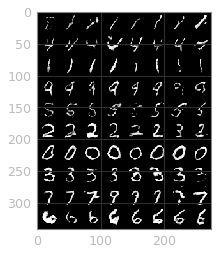

In [30]:
# words = np.arange(10)
# l = torch.from_numpy(words).cuda()


l = to_categorical(np.repeat(np.arange(10), 8), num_columns=10)
z = torch.randn(l.size(0), z_dimension).to(device)

code_x = np.repeat(np.linspace(-1, 1, 10), 8)
code_y = np.repeat(np.linspace(-1, 1, 10).reshape(1, 10), 8, axis=0).reshape(-1)
code = torch.from_numpy(np.column_stack([code_x, code_y])).float().cuda()

images = G(z, l, code)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()

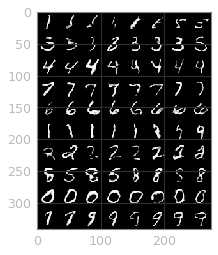

In [18]:
l = to_categorical(np.repeat(np.arange(10), 8), num_columns=10)
z = torch.randn(l.size(0), z_dimension).to(device)

code_x = np.repeat(np.linspace(-1, 1, 10), 8)
code_y = np.repeat(np.linspace(-1, 1, 10).reshape(1, 10), 8, axis=0).reshape(-1)
code = torch.from_numpy(np.column_stack([code_x, code_y])).float().cuda()

images = G(z, l, code)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()